In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import itertools
from tqdm import tqdm_notebook as tqdm
from timeit import default_timer as timer

# Locations in block units
_locations = \
      [(4, 4), # depot
       (2, 0), (8, 0), # locations to visit
       (0, 1),
       (5, 2),
       (3, 3), (6, 3),
       (5, 5), (8, 5),
       (1, 6), (2, 6),
       (0, 8), (7, 8)]

demands = [0, # depot
         1, 1, # row 0
         2,
         2,
         8, 8,
         1, 2,
         1, 2,
         8, 8]

capacities = [15, 15, 15, 15]

time_windows = \
        [(0, 0),
         (75, 85), (75, 85), # 1, 2
         (60, 70), # 3, 4
         (0, 8), # 5, 6
         (0, 10), (10, 20), # 7, 8
         (0, 10), (75, 85), # 9, 10
         (85, 95), (5, 15), # 11, 12
         (45, 55), (30, 40)] # 15, 16

def weight(node1: [float,float], node2: [float,float]):
    return math.sqrt((node1[0]-node2[0])**2
              + (node1[1]-node2[1])**2)

def powerset(iterable, lb=1):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(lb, len(s)+1))

def valid_powerset(route, routeset):
    ret = []
    for i in range(len(routeset)):
        if len(set(routeset[i][0] + route[0])) == len(routeset[i][0] + route[0]) \
           and total_distance(route) + total_distance(routeset[i]) < upper_bound_distance:
            ret.append(routeset[i])
    return ret

def total_distance(route):
    dist = G.get_edge_data(0, route[0][0])["weight"] + G.get_edge_data(0, route[0][-1])["weight"]
    for i in range(len(route[0]) - 1):
        dist += G.get_edge_data(route[0][i], route[0][i+1])["weight"]
    return dist or 2 * G.get_edge_data(0, route[0])["weight"]

G = nx.Graph(instance="Google OR example")
start = timer()

for i in range(len(_locations)):
    G.add_node(i, location=_locations[i], demand=demands[i], time_window=time_windows[i], status=0)

for i in range(len(_locations)):
    for j in range(len(_locations)):
        if i >= j:
            continue
        G.add_edge(i, j,
                   weight=math.sqrt(
                       (_locations[i][0]-_locations[j][0])**2
                       + (_locations[i][1]-_locations[j][1])**2))

# HAS TO RUN FIRST NO MATTER WHAT
def heuristics_bounds() -> dict:
    viable_routes = []
    for route in powerset(range(1, len(G.nodes))):
        demand = 0
        viable = True
        for i in route:
            if not viable:
                continue
            demand += demands[i]
            if demand > upper_bound:
                viable = False
                break
        else:
            if demand >= lower_bound:
                viable_routes += [[route, demand]]

    ret = []
    distance_upper_bound = 0

    for truck in capacities:
        # find nearest unattended customer
        current_node = 0
        nearest_neighbor = None
        min_distance = 9999999999

        max_distance = 0
        furthest_neighbor = None

        solution = [[], 0]

        for customer in range(1, len(_locations)):
            if G.node[customer]["status"]:
                continue
            if current_node == customer:
                continue
            if max_distance < G.get_edge_data(current_node, customer)["weight"]:
                max_distance = G.get_edge_data(current_node, customer)["weight"]
                furthest_neighbor = customer

        current_node = furthest_neighbor
        if current_node == None or truck < 0:
            break
        truck -= G.node[current_node]["demand"]
        G.node[current_node]["status"] = 1

        while truck > 0:
            solution[0].append(current_node)
            solution[1] += G.nodes[current_node]["demand"]

            for customer in range(1, len(_locations)):
                if G.node[customer]["status"] or current_node == customer:
                    continue
                if min_distance > G.get_edge_data(current_node, customer)["weight"]:
                    min_distance = G.get_edge_data(current_node, customer)["weight"]
                    nearest_neighbor = customer

            current_node = nearest_neighbor
            if current_node == None:
                break
            truck -= G.node[current_node]["demand"]
            if truck < 0:
                break
            G.node[current_node]["status"] = 1
            min_distance = 9999999999

        print(solution)
        ret.append(solution[1])
        this_solution_distance = sum([G.get_edge_data(solution[0][x],
                                    solution[0][x+1])["weight"]
                                    for x in range(len(solution[0]) - 1)]) \
                                    + G.get_edge_data(solution[0][-1], 0)["weight"] \
                                    + G.get_edge_data(solution[0][0], 0)["weight"]
        distance_upper_bound = max(distance_upper_bound, this_solution_distance)

    return {"lower": min(ret), "upper": distance_upper_bound}



hbounds = heuristics_bounds()
viable_routes = []
total_capacity = sum(capacities)
total_demand = sum(demands)
lower_bound = min(
    hbounds["lower"],
    total_demand % max(capacities)  # in case best route include only one truck not full
    or max(capacities),  # in case all trucks are full, lower bound can't be zero
    max(demands[1:]),)  # every truck must attend at least one customer
#     heuristic_bounds())  # exact algorithm must beat heuristics
upper_bound = max(capacities)
lower_bound_trucks = math.ceil(total_demand % max(capacities))
upper_bound_distance = hbounds["upper"]

for route in powerset(range(1, len(G.nodes))):
    demand = 0
    route_weight = 0
    viable = True
    for i in route:
        if not viable:
            continue
        demand += demands[i]
        if demand > upper_bound:
            viable = False
            break
        if total_distance([route]) > upper_bound_distance:
            viable = False
            break
    else:
        if demand >= lower_bound:
            viable_routes += [[route, demand]]
    

[[2, 4, 6, 7], 12]
[[11, 9, 10], 11]
[[3, 1, 5, 8], 13]
[[12], 8]


In [38]:
for route in tqdm(viable_routes[::-1]):
    for solution in powerset([route] + valid_powerset(route, viable_routes), lower_bound_trucks):

In [49]:
start = timer()
best_route = [[], 99999999999]
counter = 0
# for solution in powerset(viable_routes):
for route in tqdm(viable_routes[::-1]):
    if total_distance(route) > upper_bound_distance:
        print("nó podado: {}".format(route))
        continue
    for solution in powerset([route] + valid_powerset(route, viable_routes), lower_bound_trucks):
        counter += 1
        attended_demand = sum([x[1] for x in solution])
        coverage = set(i for x in solution for i in x[0])
#         print(solution)
#         print(attended_demand, total_demand, total_capacity, coverage)
        if  total_demand <= attended_demand <= total_capacity and len(coverage) == len(G.nodes) - 1:
            total_weight = sum([G.get_edge_data(x[0][i], x[0][i+1])["weight"] for x in solution for i in range(len(x[0])-1)])
            if total_weight < best_route[1]:
                best_route = [solution, total_weight]
                print(best_route, timer() - start)
        if counter % 10000000 == 0:
            print("{} at {}/s".format(counter, counter/(timer() - start)))
best_route

10000000 at 211839.03130917018/s
20000000 at 212470.01829251667/s
30000000 at 208886.8492248838/s
40000000 at 206335.38388542994/s
50000000 at 203436.74418161833/s


KeyboardInterrupt: 

In [102]:
MST = nx.algorithms.tree.minimum_spanning_tree(G, algorithm="prim", weight="weight")

In [6]:
def ktree(G: nx.Graph, k: int) -> nx.Graph:
    mst = nx.algorithms.tree.minimum_spanning_tree(G, algorithm="prim", weight="weight")
    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    
    while(len(mst.edges) < (len(mst.nodes) + k - 1)):
        for edge in edges:
            if not mst.get_edge_data(edge[0], edge[1]):
                mst.add_edge(edge[0], edge[1], weight=edge[2]["weight"])
            if len(mst.edges) == (len(mst.nodes) + k - 1):
                break
    
    print (len(mst.edges), len(mst.nodes))
    # assert(len(mst.edges) < (len(mst.nodes) + k - 1))
    
    # TODO: step 0: make a copy of mst called ktree
    ktree = nx.Graph(mst)
    
    
    while ktree.degree[0] > 2*k:
        # TODO: step 1: store edges on node 0 (depot), ordered by highest weight
        depot_edges = sorted(mst.edges(0, data=True), key=lambda x: -x[2]['weight'])
        
        # TODO: step 2: remove all edges on depot
        ktree.remove_edges_from(depot_edges)
        
        # TODO: step 3: label nodes according to their connected components
        connected_components = list(nx.connected_components(ktree))
        
        # TODO: step 4: add those depot_edges again
        # ktree = nx.Graph(mst)
        
        # TODO: step 5: REMEMBER ONLY COMPONENTS WITH 2+ EDGES TO DEPOT CAN BE DISCONNECTED
        # but they'll be changing during this execution
        # this is going to be a difficult but crucial step
        
        # TODO: step 6: for every edge between customers, compute a cost function w(c1, c2):
        # w(c1,c2) = G.get_edge_data(c1, c2)["weight"] - depot_edges[0][2]["weight"] if label(c1) == label(c2)
        # else G.get_edge_data(c1, c2)["weight"] - max(depot_edges[0][2]["weight"], depot_edge to label(c1)["weight"], depot_edge to label(c2)["weight"])
        # REMEMBER TO STORE THE COMBINATION PICKED (c1, c2, which depot_edge)
        
        # TODO: step 7: if min(w(c1,c2)) from label(c1) == label(c2):
        # remove depot_edges[0][2] from ktree
        # delete depot_edges[0][2]
        # ktree.add_edge(c1,c2,G.get_edge_data(c1, c2)["weight"])
        # ??? maybe ktree.add_edge(G.edges(c1,c2)) ???
        # else:
        # remove depot_edge from ktree
        # delete depot_edge
        # add best edge (according to min(w(c1,c2))) to ktree
        # for all edges which label == label(c2): label = label(c1) since they're now connected
        
    while ktree.degree[0] < 2*k:
        pass
        # TODO: I have no idea 
        
        # TODO: step 1: store edges on node 0 (depot), ordered by highest weight
        depot_edges = sorted(mst.edges(0, data=True), key=lambda x: -x[2]['weight'])
        
        # TODO: step 2: remove all edges on depot
        ktree.remove_edges_from(depot_edges)
        
        # TODO: step 3: label nodes according to their connected components
        connected_components = list(nx.connected_components(ktree))
        
        # TODO: step 4: add those depot_edges again
        # ktree = nx.Graph(mst)
        
        # TODO: step 5: REMEMBER ONLY COMPONENTS WITH <2 EDGES TO DEPOT NEED TO BE CONNECTED
        # but they'll be changing during this execution
        # this is going to be a difficult but crucial step
        
        # TODO: step 6: for every edge between customers, compute a cost function w(c1, c2):
        # w(c1,c2) = G.get_edge_data(c1, c2)["weight"] - depot_edges[0][2]["weight"] if label(c1) == label(c2)
        # else G.get_edge_data(c1, c2)["weight"] - max(depot_edges[0][2]["weight"], depot_edge to label(c1)["weight"], depot_edge to label(c2)["weight"])
        # REMEMBER TO STORE THE COMBINATION PICKED (c1, c2, which depot_edge)
        
        # TODO: step 7: if min(w(c1,c2)) from label(c1) == label(c2):
        # remove depot_edges[0][2] from ktree
        # delete depot_edges[0][2]
        # ktree.add_edge(c1,c2,G.get_edge_data(c1, c2)["weight"])
        # ??? maybe ktree.add_edge(G.edges(c1,c2)) ???
        # else:
        # remove depot_edge from ktree
        # delete depot_edge
        # add best edge (according to min(w(c1,c2))) to ktree
        # for all edges which label == label(c2): label = label(c1) since they're now connected
        
    assert ktree.degree[0] == 2*k
    for i in len(ktree.nodes):
        assert ktree.degree[i] == 2
        
    return ktree

In [27]:
m = nx.Graph(MST)
m.remove_node(0)
list(nx.connected_components(m))

[{1, 3, 5}, {2, 4, 6, 8, 12}, {7}, {9, 10, 11}]

In [7]:
ktree(G, 2)

14 13


KeyboardInterrupt: 

In [104]:
sorted(G.edges(data=True), key=lambda x: x[2]['weight'])

[(9, 10, {'weight': 1.0}),
 (0, 5, {'weight': 1.4142135623730951}),
 (0, 7, {'weight': 1.4142135623730951}),
 (4, 6, {'weight': 1.4142135623730951}),
 (0, 4, {'weight': 2.23606797749979}),
 (0, 6, {'weight': 2.23606797749979}),
 (1, 3, {'weight': 2.23606797749979}),
 (4, 5, {'weight': 2.23606797749979}),
 (6, 7, {'weight': 2.23606797749979}),
 (9, 11, {'weight': 2.23606797749979}),
 (0, 10, {'weight': 2.8284271247461903}),
 (5, 7, {'weight': 2.8284271247461903}),
 (6, 8, {'weight': 2.8284271247461903}),
 (10, 11, {'weight': 2.8284271247461903}),
 (4, 7, {'weight': 3.0}),
 (5, 6, {'weight': 3.0}),
 (7, 8, {'weight': 3.0}),
 (1, 5, {'weight': 3.1622776601683795}),
 (5, 10, {'weight': 3.1622776601683795}),
 (7, 10, {'weight': 3.1622776601683795}),
 (8, 12, {'weight': 3.1622776601683795}),
 (0, 9, {'weight': 3.605551275463989}),
 (1, 4, {'weight': 3.605551275463989}),
 (2, 4, {'weight': 3.605551275463989}),
 (2, 6, {'weight': 3.605551275463989}),
 (3, 5, {'weight': 3.605551275463989}),
 (5

In [105]:
mst = nx.algorithms.tree.minimum_spanning_tree(G, algorithm="prim", weight="weight")
sorted(mst.edges(data=True), key=lambda x: x[2]['weight'])

[(9, 10, {'weight': 1.0}),
 (0, 5, {'weight': 1.4142135623730951}),
 (0, 7, {'weight': 1.4142135623730951}),
 (4, 6, {'weight': 1.4142135623730951}),
 (0, 4, {'weight': 2.23606797749979}),
 (1, 3, {'weight': 2.23606797749979}),
 (9, 11, {'weight': 2.23606797749979}),
 (0, 10, {'weight': 2.8284271247461903}),
 (6, 8, {'weight': 2.8284271247461903}),
 (1, 5, {'weight': 3.1622776601683795}),
 (8, 12, {'weight': 3.1622776601683795}),
 (2, 4, {'weight': 3.605551275463989})]

In [7]:
def all_partitions(collection):
    """Returns the set of all partitions for a given set
    e.g for [1,2], it returns [[1],[2]] and [[1,2]]
    https://stackoverflow.com/questions/19368375/set-partitions-in-python
    """
    if len(collection) == 1:
        yield [collection]
        return
    first = collection[0]
    for smaller in all_partitions(collection[1:]):
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[first] + subset] + smaller[n + 1:]
        yield [[first]] + smaller

def k_partitions_with_shortest_routes(ids, k=1):
    """Our partitions represent number of vehicles. This function yields
     an optimal path for each vehicle given the destinations assigned to it"""
    for p in filter(lambda x: len(x) == k, all_partitions(ids[1:])):
        yield [min(all_routes([ids[0]] + q), key=route_length) for q in p]


def shortest_partition(ids, k=3):
    """This function receives all k-subsets of a route and returns the subset
    with minimum distance cost. Note the total time is always equal to
    the max time taken by any single vehicle"""
    return min(k_partitions_with_shortest_routes(ids, k),
               key=lambda x: max(route_length(x[i]) for i in range(k)))


In [111]:
k = 2  # trucks

mst = nx.algorithms.tree.minimum_spanning_tree(G, algorithm="prim", weight="weight")
edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])

while(len(mst.edges) < (len(mst.nodes) + k - 1)):
    for edge in edges:
        if not mst.get_edge_data(edge[0], edge[1]):
            mst.add_edge(edge[0], edge[1], weight=edge[2]["weight"])
        if len(mst.edges) == (len(mst.nodes) + k - 1):
            break

print (len(mst.edges), len(mst.nodes))
# assert(len(mst.edges) < (len(mst.nodes) + k - 1))

14 13


In [112]:
# TODO: step 0: make a copy of mst called ktree
ktree = nx.Graph(mst)


# while ktree.degree[0] > 2*k:


# TODO: step 1: store edges on node 0 (depot), ordered by highest weight
depot_edges = sorted(mst.edges(0, data=True), key=lambda x: -x[2]['weight'])

# TODO: step 2: remove all edges on depot
ktree.remove_edges_from(depot_edges)

# TODO: step 3: label nodes according to their connected components
connected_components = list(nx.connected_components(ktree))
dict_cc = {}
edges_to_depot = {}

for i in range(1, len(connected_components)):
    edges_to_depot[i] = 0
    for j in connected_components[i]:
        dict_cc[j] = i
        if mst.get_edge_data(0, j):
            edges_to_depot[i] += 1
            
        

In [ ]:
# TODO: step 4: add those depot_edges again
# ktree = nx.Graph(mst)
# no need to, mst still holds these edges

# TODO: step 5: REMEMBER ONLY COMPONENTS WITH 2+ EDGES TO DEPOT CAN BE DISCONNECTED
# but they'll be changing during this execution
# this is going to be a difficult but crucial step

# TODO: step 6: for every edge between customers, compute a cost function w(c1, c2):
# w(c1,c2) = G.get_edge_data(c1, c2)["weight"] - depot_edges[0][2]["weight"] if label(c1) == label(c2)
# else G.get_edge_data(c1, c2)["weight"] - max(depot_edges[0][2]["weight"], depot_edge to label(c1)["weight"], depot_edge to label(c2)["weight"])
# REMEMBER TO STORE THE COMBINATION PICKED (c1, c2, which depot_edge)
combination = ((get_best_edge_to_add(mst, G)[:2]), (heaviest_available_depot_edge(depot_edges, dict_cc, edges_to_depot)[:2]))

# TODO: step 7: if min(w(c1,c2)) from label(c1) == label(c2):
if dict_cc[combination[0][0]] == dict_cc[combination[0][1]]:
    mst.remove_edge(combination[1][0], combination[1][1])
    mst.add_edge(combination[0][0], combination[0][1], weight=G.get_edge_data(combination[0][0], combination[0][1])["weight"])
else:
    mst.remove_edge(combination[1][0], combination[1][1])
    mst.add_edge(combination[0][0], combination[0][1], weight=G.get_edge_data(combination[0][0], combination[0][1])["weight"])
    cc_to_change = dict_cc[combination[0][1]]
    new_cc_label = dict_cc[combination[0][0]]
    for key, value in dict_cc.items():
        if value == cc_to_change:
            dict_cc[key] == new_cc_label

In [115]:
ktree = nx.Graph(mst)
ktree.remove_edges_from(depot_edges)

# remove depot_edges[0][2] from ktree
# delete depot_edges[0][2]
# ktree.add_edge(c1,c2,G.get_edge_data(c1, c2)["weight"])
# ??? maybe ktree.add_edge(G.edges(c1,c2)) ???
# else:
# remove depot_edge from ktree
# delete depot_edge
# add best edge (according to min(w(c1,c2))) to ktree
# for all edges which label == label(c2): label = label(c1) since they're now connected

In [89]:
edges_to_depot

{1: 3, 2: 1, 3: 1}

In [66]:
dict_cc

{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 8: 1, 12: 1, 7: 2, 9: 3, 10: 3, 11: 3}

/home/ramon/.local/share/virtualenvs/otimgraf-s98R5NnN/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


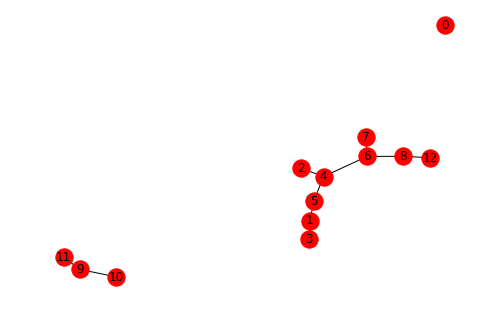

In [116]:
nx.draw(ktree, with_labels=True)

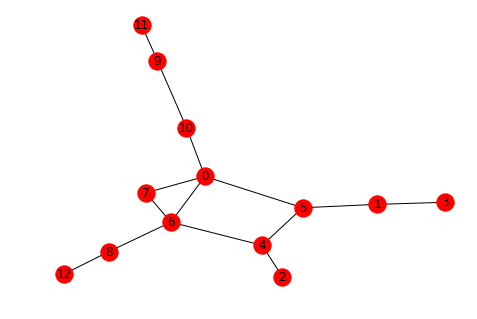

In [114]:
nx.draw(mst, with_labels=True)

In [37]:
depot_edges

[(0, 10, {'weight': 2.8284271247461903}),
 (0, 4, {'weight': 2.23606797749979}),
 (0, 6, {'weight': 2.23606797749979}),
 (0, 5, {'weight': 1.4142135623730951}),
 (0, 7, {'weight': 1.4142135623730951})]

In [28]:
connected_components

[{0}, {1, 2, 3, 4, 5, 6, 8, 12}, {7}, {9, 10, 11}]

In [ ]:
while ktree.degree[0] < 2*k:
    pass
    # TODO: I have no idea 

assert ktree.degree[0] == 2*k
for i in len(ktree.nodes):
    assert ktree.degree[i] == 2

return ktree

In [40]:
def node_label(node: int, list_of_components: list):
    for i in range(list_of_components):
        if node in list_of_components[i]:
            return i

In [69]:
# TODO: step 6: for every edge between customers, compute a cost function w(c1, c2):
# w(c1,c2) = G.get_edge_data(c1, c2)["weight"] - depot_edges[0][2]["weight"] if label(c1) == label(c2)
# else G.get_edge_data(c1, c2)["weight"] - max(depot_edges[0][2]["weight"], depot_edge to label(c1)["weight"], depot_edge to label(c2)["weight"])
# REMEMBER TO STORE THE COMBINATION PICKED (c1, c2, which depot_edge)

# TODO: missing parameters 
def cost_w(c1: int, c2: int):
    if dict_cc[c1] == dict_cc[c2]:
        return (c1, c2, G.get_edge_data(c1, c2)["weight"]
                - heaviest_available_depot_edge(depot_edges, dict_cc, edges_to_depot)[2]["weight"])
    else:
        dist_to_label_c1 = get_distance_to_component(connected_components[dict_cc[c1]])
        dist_to_label_c2 = get_distance_to_component(connected_components[dict_cc[c2]])
        return (c1, c2, G.get_edge_data(c1, c2)["weight"] - max(
            heaviest_available_depot_edge(depot_edges, dict_cc, edges_to_depot)[2]["weight"],
            dist_to_label_c1[1],
            dist_to_label_c2[1]))

In [101]:
def get_best_edge_to_add(mst: nx.Graph, G: nx.Graph):
    min_cost_w = 999999999999999
    min_cost_edge = tuple()

    for e1 in list(G.nodes)[1:]:
        for e2 in list(G.nodes)[e1+1:]:
            if mst.get_edge_data(e1, e2):
                continue
            if min_cost_w > cost_w(e1, e2)[2]:
                min_cost_w = cost_w(e1, e2)[2]
                min_cost_edge = (e1, e2)
        
    return min_cost_edge + (min_cost_w,) 

In [82]:
def get_distance_to_component(set_of_component: set) -> tuple:
    component = list(set_of_component)
    values = [G.get_edge_data(0, i)["weight"] for i in component]
    index_min = min(range(len(values)), key=values.__getitem__)
    return (index_min, values[index_min])

In [51]:
def heaviest_available_depot_edge(depot_edges, dict_cc, edges_to_depot):
    for i in depot_edges:
        if edges_to_depot[dict_cc[i[1]]] < 2:
            continue
        return i

In [93]:
heaviest_available_depot_edge(depot_edges, dict_cc, edges_to_depot)

(0, 4, {'weight': 2.23606797749979})

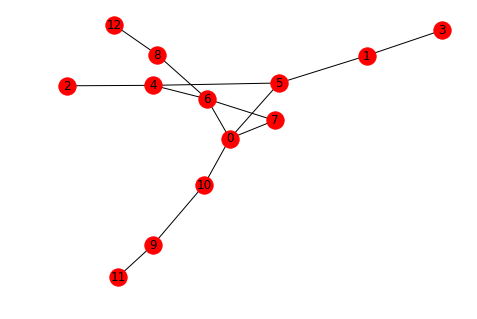

In [100]:
nx.draw(mst, with_labels=True)

In [2]:
from timeit import default_timer as timer

def find_solution(viable_routes, trucks_left, solution):
    if trucks_left <= 0:
        print("no trucks left")
        return False

    attended_demand = sum([x[1] for x in solution])
    coverage = set(i for x in solution for i in x[0])

    if attended_demand == total_demand <= total_capacity \
       and len(coverage) == len(G.nodes) - 1:
        total_weight = sum(
            [G.get_edge_data(x[0][i], x[0][i+1])["weight"]
            for x in solution for i in range(len(x[0])-1)])
        print("solution: {}, weight: {}, time: {}".format(
           solution, total_weight, timer() - start))
        return solution

    else:
        print(solution + [viable_routes[0]])
        return find_solution(viable_routes[1:], trucks_left-1, solution + [viable_routes[0]]) or find_solution(viable_routes[2:], trucks_left-1, solution + [viable_routes[0]])

In [3]:
start = timer()
find_solution(viable_routes, trucks_left=len(capacities), solution=[])

[[(3, 4, 5, 8), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 8), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 8), 14], [(3, 4, 6, 10), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 8), 14], [(3, 4, 8, 11), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 10), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 10), 14], [(3, 4, 8, 11), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 5, 10), 14], [(3, 4, 6, 10), 14], [(3, 4, 8, 12), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 6, 8), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 6, 8), 14], [(3, 4, 6, 10), 14]]
[[(3, 4, 5, 8), 14], [(3, 4, 6, 8), 14], [(3, 4, 6, 10), 14], [(3, 4, 8, 11), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 6, 8), 14], [(3, 4, 6, 10), 14], [(3, 4, 8, 12), 14]]
no trucks left
no trucks left
[[(3, 4, 5, 8), 14], [(3, 4, 

False

In [4]:
viable_routes

[[(3, 4, 5, 8), 14],
 [(3, 4, 5, 10), 14],
 [(3, 4, 6, 8), 14],
 [(3, 4, 6, 10), 14],
 [(3, 4, 8, 11), 14],
 [(3, 4, 8, 12), 14],
 [(3, 4, 10, 11), 14],
 [(3, 4, 10, 12), 14],
 [(3, 5, 8, 10), 14],
 [(3, 6, 8, 10), 14],
 [(3, 8, 10, 11), 14],
 [(3, 8, 10, 12), 14],
 [(4, 5, 8, 10), 14],
 [(4, 6, 8, 10), 14],
 [(4, 8, 10, 11), 14],
 [(4, 8, 10, 12), 14],
 [(1, 2, 3, 4, 5), 14],
 [(1, 2, 3, 4, 6), 14],
 [(1, 2, 3, 4, 11), 14],
 [(1, 2, 3, 4, 12), 14],
 [(1, 2, 3, 5, 8), 14],
 [(1, 2, 3, 5, 10), 14],
 [(1, 2, 3, 6, 8), 14],
 [(1, 2, 3, 6, 10), 14],
 [(1, 2, 3, 8, 11), 14],
 [(1, 2, 3, 8, 12), 14],
 [(1, 2, 3, 10, 11), 14],
 [(1, 2, 3, 10, 12), 14],
 [(1, 2, 4, 5, 8), 14],
 [(1, 2, 4, 5, 10), 14],
 [(1, 2, 4, 6, 8), 14],
 [(1, 2, 4, 6, 10), 14],
 [(1, 2, 4, 8, 11), 14],
 [(1, 2, 4, 8, 12), 14],
 [(1, 2, 4, 10, 11), 14],
 [(1, 2, 4, 10, 12), 14],
 [(1, 2, 5, 8, 10), 14],
 [(1, 2, 6, 8, 10), 14],
 [(1, 2, 8, 10, 11), 14],
 [(1, 2, 8, 10, 12), 14],
 [(1, 3, 4, 5, 7), 14],
 [(1, 3, 4, 5, 8), 1

In [15]:
def permutation(list, start, end):
    '''This prints all the permutations of a given list
       it takes the list,the starting and ending indices as input'''
    if (start == end):
        print(list)
    else:
        for i in range(start, end + 1):
            list[start], list[i] = list[i], list[start]  # The swapping
            permutation(list, start + 1, end)
            list[start], list[i] = list[i], list[start]  # Backtracking


permutation([1, 2, 3, 4, 5], 0, 2)  # The first index of a list is zero


[1, 2, 3, 4, 5]
[1, 3, 2, 4, 5]
[2, 1, 3, 4, 5]
[2, 3, 1, 4, 5]
[3, 2, 1, 4, 5]
[3, 1, 2, 4, 5]


In [40]:
v_r = viable_routes[:]

In [5]:
while len(v_r) > 0:
    total_trucks = 0
    attended_demand = 0
    indexes = range(1, len(capacities))
    solution = []
    solution_weight = 9999999999999
    # while total_trucks <= len(capacities):
    solution += [v_r[0]]
    
    total_trucks += 1
    attended_demand = sum([x[1] for x in solution])
    coverage = set(i for x in solution for i in x[0])
    
    for i in range(1, len(capacities)):
        solution += [viable_routes[i]]
        total_trucks += 1
        attended_demand = sum([x[1] for x in solution])
        coverage = set(i for x in solution for i in x[0])
        
        if attended_demand == total_demand <= total_capacity \
           and len(coverage) == len(G.nodes) - 1:
            total_weight = sum(
                [G.get_edge_data(x[0][i], x[0][i+1])["weight"]
                for x in solution for i in range(len(x[0])-1)])
            print("solution: {}, weight: {}, time: {}".format(
               solution, total_weight, timer() - start))
            
            for k in range(j+1, len(viable_routes)):
                solution += [viable_routes[i]]
                total_trucks += 1
                attended_demand = sum([x[1] for x in solution])
                coverage = set(i for x in solution for i in x[0])
                for l in range(k+1, len(viable_routes)):
                    solution += [viable_routes[i]]
                    total_trucks += 1
                    attended_demand = sum([x[1] for x in solution])
                    coverage = set(i for x in solution for i in x[0])

KeyboardInterrupt: 

In [ ]:
for route in viable_routes:
    

In [51]:
list(powerset([r1] + valid_powerset(r1, v_r)))

[([(3, 4, 5, 8), 14],),
 ([(1, 2, 6, 7, 9, 10), 14],),
 ([(1, 2, 7, 9, 10, 11), 14],),
 ([(1, 2, 7, 9, 10, 12), 14],),
 ([(3, 4, 5, 8), 14], [(1, 2, 6, 7, 9, 10), 14]),
 ([(3, 4, 5, 8), 14], [(1, 2, 7, 9, 10, 11), 14]),
 ([(3, 4, 5, 8), 14], [(1, 2, 7, 9, 10, 12), 14]),
 ([(1, 2, 6, 7, 9, 10), 14], [(1, 2, 7, 9, 10, 11), 14]),
 ([(1, 2, 6, 7, 9, 10), 14], [(1, 2, 7, 9, 10, 12), 14]),
 ([(1, 2, 7, 9, 10, 11), 14], [(1, 2, 7, 9, 10, 12), 14]),
 ([(3, 4, 5, 8), 14], [(1, 2, 6, 7, 9, 10), 14], [(1, 2, 7, 9, 10, 11), 14]),
 ([(3, 4, 5, 8), 14], [(1, 2, 6, 7, 9, 10), 14], [(1, 2, 7, 9, 10, 12), 14]),
 ([(3, 4, 5, 8), 14], [(1, 2, 7, 9, 10, 11), 14], [(1, 2, 7, 9, 10, 12), 14]),
 ([(1, 2, 6, 7, 9, 10), 14],
  [(1, 2, 7, 9, 10, 11), 14],
  [(1, 2, 7, 9, 10, 12), 14]),
 ([(3, 4, 5, 8), 14],
  [(1, 2, 6, 7, 9, 10), 14],
  [(1, 2, 7, 9, 10, 11), 14],
  [(1, 2, 7, 9, 10, 12), 14])]

In [41]:
%%timeit
valid_powerset(r1, v_r)

249 µs ± 6.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
[r1] + valid_powerset(r1, v_r)

[[(3, 4, 5, 8), 14],
 [(1, 2, 6, 7, 9, 10), 14],
 [(1, 2, 7, 9, 10, 11), 14],
 [(1, 2, 7, 9, 10, 12), 14]]

In [52]:
%%timeit
list(powerset([r1] + valid_powerset(r1, v_r)))    

249 µs ± 3.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
